# Option Pricing based on Heston and Black-Scholes Model

We use Monte Carlo simulation to implement the Heston and Black-Scholes model

In [7]:
import os
import time
import pathlib
# import numba # potential speed up here
# import cupy as cp # only works with nvidia gpu
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm

## 0 Heston model for scalar values

We first implement a scalar version of the model according to the following formulae.  

$$d S_t  = \mu S_t dt + \sqrt{\nu_t} S_t dW^S_t \\ d \nu_t = \kappa (\theta - \nu_t) dt + \xi \sqrt{\nu_t} dW^\nu_t$$  

which is discretized as  

$$
S_{i+1} = S_i \exp [\left(\mu - \frac{1}{2} v_i^{+}\right) \Delta t + \sqrt{v_i^{+}} \sqrt{\Delta t} \Delta W^S_{i+1}] \\
\nu_{i+1} = \nu_i + \kappa (\theta - \nu_i^{+}) \Delta t + \xi \sqrt{\nu_i^{+}} \Delta W^\nu_{i+1}
$$

In [8]:
# set some parameters
num_sims = 100000;   # Number of simulated asset paths
num_intervals = 1000;  # Number of intervals for the asset path to be sampled 

S_0 = 100.0;    # Initial spot price
K = 100.0;      # Strike price
r = 0.0319;     # Risk-free rate
v_0 = 0.010201; # Initial volatility 
T = 1.00;       # One year until expiry

rho = -0.7;     # Correlation of asset and volatility
kappa = 6.21;   # Mean-reversion rate
theta = 0.019;  # Long run average volatility
xi = 0.61;      # "Vol of vol"

In [9]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, num_sims):  
    '''
    Produces result for a single heston run.
    
    '''
    dt = T/steps
    # size = (num_sims, steps)
    # prices = np.zeros(size)
    # vols = np.zeros(size)
    S_t = S + np.zeros(num_sims)
    v_t = v_0 + np.zeros(num_sims)
    for t in tqdm(range(steps), colour="green"):
    # for t in range(steps):
        # [hex (#00ff00), BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE]
        WT1 = np.random.normal(0,1,size=num_sims)
        WT2 = np.random.normal(0,1,size=num_sims)
        WT3 = rho * WT1 + np.sqrt(1-rho**2)*WT2
        # WT = np.vstack((WT1, WT3)).T

        v_t = np.maximum(v_t, 0)
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t * dt) * WT1 )) #WT[:,0]
        v_t = v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t * dt)*WT3    #WT[:,1]
        # prices[:, t] = S_t # can be returned when plotting is required
        # vols[:, t] = v_t   # omitted to save memory 
    
    S_call = np.exp(-1 * r * T) * np.sum(np.maximum(S_t - K, 0)) / num_sims
    S_put = np.exp(-1 * r * T) * np.sum(np.maximum(K-S_t, 0)) / num_sims
    nu_avg = np.mean(v_t)
    
    return [S_call, S_put, nu_avg]

In [10]:
result = generate_heston_paths(S_0, T, r, kappa, theta, v_0,
                      rho, xi, num_intervals, num_sims)

100%|██████████| 1000/1000 [00:04<00:00, 234.87it/s]


In [11]:
for x in result:
  print(x)

6.860338360872788
3.6995363861917063
0.019109166689533073


## 1 Heston model for vector values 

To produce a large number of results, we need to utilize the built-in vectorization in `numpy`.

In [33]:
def generate_heston_vec(df, steps=1000, num_sims=100000):  

    '''
    Produces result for multiple heston runs for call options only.

    Args:  
        - df: dataframe, containing all parameters
        - steps: int, num time steps
        - num_sims: int, no. of simulations for each sample  

    Output:  
        - result: ndarray, containing average prices over num_sims
    '''  

    N     = len(df)
    # out   = np.zeros((N, ))
    dt    = df['days_to_maturity'].values /steps 
    S_t   = df['underlyings_price'].values 
    v_t   = df['volatility'].values 
    r     = df['rate'].values 
    theta = df['mean_volatility'].values 
    kappa = df['reversion'].values 
    xi    = df['var_of_vol'].values 
    K     = df['strike'].values 
    rho   = df['rho'].values 
    T     = df['days_to_maturity'].values * 365
    
    for t in tqdm(range(steps), colour="green"):
        
        # the random normal samples are of shape (num_sims, N)
        WT1 = np.random.normal(0,1,size=(num_sims, N))
        WT2 = np.random.normal(0,1,size=(num_sims, N))
        WT3 = rho * WT1 + np.sqrt(1-rho**2)*WT2

        v_t = np.maximum(v_t, 0)
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t * dt) * WT1 )) 
        v_t = v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t * dt)*WT3
    
    S_call = np.exp(-1 * r * T) * np.sum(np.maximum(S_t - K, 0), axis = 0) / num_sims
    
    # S_put = np.exp(-1 * r * T) * np.sum(np.maximum(K-S_t, 0)) / num_sims
    nu_avg = np.mean(v_t)
    
    return S_call

We first load data for experiment and preprocess (roughly)

In [34]:
parent_path = str(pathlib.Path(os.getcwd()).parent)
compressed = False
if compressed:
    import zipfile
    parent_path = str(pathlib.Path(os.getcwd()).parent)
    with zipfile.ZipFile(parent_path + "/data/combined.zip","r") as zip_ref:
        zip_ref.extractall(parent_path+"/data/")

In [35]:
df = pd.read_csv(os.path.join(parent_path, 'data/data.csv'))

print(df.shape)

df.sample(5)

(107499, 14)


,Unnamed: 0,optionid,securityid,strike,callput,date_traded,contract_price,market_price,underlyings_price,contract_volume,days_to_maturity,moneyness,rate,volatility
24140,24634,150080692.0,506534.0,4.40,C,2006-06-22,0.2150,0.22225,4.292600,546.0,358.0,0.975591,0.056686,0.224718
30057,30570,156798592.0,506534.0,4.80,C,2007-08-07,0.3900,0.39000,5.214300,5.0,10.0,1.086312,0.053915,0.153294
47850,48371,153930305.0,702263.0,12.60,C,2013-07-12,0.0550,0.05500,12.133000,435.0,35.0,0.962937,0.001999,0.210271
29244,29757,156791771.0,506534.0,6.40,C,2007-07-09,0.0785,0.07800,5.574300,10.0,347.0,0.870984,0.053989,0.104922
7485,7622,150042968.0,506528.0,63.75,C,2006-10-30,0.1800,0.19000,61.267998,357.0,46.0,0.961067,0.054120,0.077493


Here we use (almost) the same approach to model average long run volatility $\theta$, mean reversion rate of volatility $\kappa$, and the variance of volatility $\xi$.  

**Question:** Is this the best approach? Are there better approaches? Perhaps options with the same underlying asset should take correlated values?

In [36]:
# drop contract volume
df.drop(['contract_volume'], axis = 1)

# drop small strike prices
df = df.drop(df[df.strike<0.1].index)

# We may  add the following to the function for heston simulation

# add average long run volatility (theta)
df['mean_volatility'] = 0.001 + 0.05 * np.random.rand(len(df))

# add mean reversion rate of volatility (kappa)
df['reversion'] = 0.01 + 5 * np.random.rand(len(df))

# add variance of volatility
df['var_of_vol'] = 0.01 + 0.7 * np.random.rand(len(df))

# add correlation between random processes  
df['rho'] = -0.05 - 0.7 * np.random.rand(len(df))

df.head()

,Unnamed: 0,optionid,securityid,strike,callput,date_traded,contract_price,market_price,underlyings_price,contract_volume,days_to_maturity,moneyness,rate,volatility,mean_volatility,reversion,var_of_vol,rho
0,0,150034236.0,504569.0,0.42,C,2006-10-18,0.0715,0.07025,0.488500,5.0,2.0,1.163095,0.053646,0.022956,0.011451,2.802118,0.101625,-0.162263
1,1,150247468.0,504880.0,40.00,C,2006-10-18,0.1240,0.12250,39.913799,56137.0,2.0,0.997845,0.053646,0.114784,0.035902,4.767512,0.578068,-0.193211
2,2,150255000.0,506496.0,62.00,C,2006-10-18,0.1720,0.17400,61.827798,27369.0,2.0,0.997223,0.053646,0.106823,0.016338,0.025482,0.238603,-0.563278
3,3,150255496.0,506497.0,53.50,C,2006-10-18,0.2960,0.26550,53.612900,1224.0,2.0,1.002110,0.053646,0.110336,0.006554,3.623960,0.145991,-0.415630
4,4,150255498.0,506497.0,54.00,C,2006-10-18,0.0750,0.06450,53.612900,963.0,2.0,0.992831,0.053646,0.110336,0.048223,2.524372,0.392393,-0.322703


For the ease of computation, we halve/reduce the size of `df`

In [37]:
df = df.sample(int(0.01*len(df)))

In [38]:
df.shape

(1074, 18)

## 2 Black-Scholes Model for vector values  

We implement the call/put option price of a Black-Scholes Model analystically according the following formulae.  

$$
\begin{aligned}
C(S,t) &= SN(d_1) - Ke^{-rT} N(d_2) \\
P(S,t) &= Ke^{-rT} - S + (SN(d_1) - Ke^{-rT} N(d_2))
\end{aligned}
$$  

where $N(x)$ is the cdf. of a standard normal distribution and $d_1,d_2$ are defined as  

$$
\begin{aligned}
d_1 &= \frac{\log(S/K) + (r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T} }\\
d_2 &= d_1 - \sigma \sqrt{T}
\end{aligned}
$$

In [39]:
def generate_bs_vec(df):
    """
    Produces result for multiple B-S runs for call options only (analytical).  

    Args:
        - df: dataframe, containing all parameters

    Output:
        - result: ndarray, containing prices for each sample
    """
    S   = df['underlyings_price'].values 
    vol   = df['volatility'].values 
    r     = df['rate'].values   
    K     = df['strike'].values  
    T     = df['days_to_maturity'].values / 365
    m     = df['moneyness'].values

    d1 = (np.log(m) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    S_call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return S_call


## 1.1 Testing implementation  

We will test the implementation on a dummy dataset with repeated values; this is also useful for trying out models for the aforementioned constants.

In [40]:
# creates dummy dataset

N = len(df)

S_0 = np.repeat(100.0, N)     # Initial spot price
K = np.repeat(100.0, N)       # Strike price
r = np.repeat(0.0319, N)      # Risk-free rate
v_0 = np.repeat(0.010201,N)   # Initial volatility 
T = np.repeat(1.0, N)         # One year until expiry

rho = np.repeat(-0.7, N)      # Correlation of asset and volatility
kappa = np.repeat(6.21, N)    # Mean-reversion rate
theta = np.repeat(0.019,N)    # Long run average volatility
xi = np.repeat(0.61,N)        # "Vol of vol"  

dummy = pd.DataFrame(columns=['underlyings_price', 'strike', 'rate', 
                    'days_to_maturity', 'volatility', 'mean_volatility', 
                    'reversion', 'var_of_vol', 'rho'])

dummy['days_to_maturity'] = T
dummy['underlyings_price'] = S_0
dummy['volatility'] = v_0
dummy['rate'] = r
dummy['mean_volatility'] = theta
dummy['reversion'] = kappa
dummy['var_of_vol'] = xi
dummy['strike'] = K
dummy['rho'] = rho

dummy.head()

,underlyings_price,strike,rate,days_to_maturity,volatility,mean_volatility,reversion,var_of_vol,rho
0,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
1,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
2,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
3,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
4,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7


If tested on dummy dataset, then output should be approx. normally distributed which verifies the implementation of the heston model

In [42]:
# test_output = generate_heston_vec(dummy, 1000, 100)
test_output_heston = generate_heston_vec(df, 1000, 100)
test_output_bs = generate_bs_vec(df)

test_output_heston = np.sum((test_output_heston - df['contract_price'].values)**2) / len(df)
test_output_bs = np.sum((generate_bs_vec(df) - df['contract_price'].values)**2) / len(df)

print('MSE for Heston: ', test_output_heston)
print('MSE for B-S: ', test_output_bs)

100%|██████████| 1000/1000 [00:04<00:00, 212.21it/s]

MSE for Heston:  0.09078084079816295
MSE for B-S:  0.24962708393787258



/var/folders/qd/mrmrksmj4v792bqkk9kgwv380000gn/T/ipykernel_96642/499682573.py:18: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(m) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([62.55822394, 62.56822394, 62.57822394, 62.58822394, 62.59822394,
        62.60822394, 62.61822394, 62.62822394, 62.63822394, 62.64822394,
        62.65822394, 62.66822394, 62.67822394, 62.68822394, 62.69822394,
        62.70822394, 62.71822394, 62.72822394, 62.73822394, 62.74822394,
        62.75822394, 62.76822394, 62.77822394, 62.78822394, 62.79822394,
        62.80822394, 62.81822394, 62.82822394, 62.83822394, 62.84822394,
        62.85822394, 62.86822394, 62.87822394, 62.88822394, 62.89822394,
        62.90822394, 62.91822394, 62.92

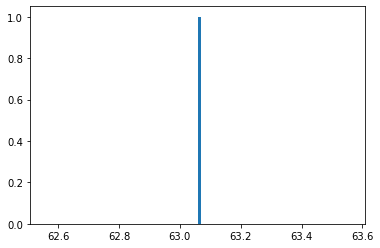

In [19]:
import matplotlib.pyplot as plt
plt.hist(test_output_heston, bins = 100)
plt.hist(test_output_bs, bins = 100)